<h1>LSTM Modeling</h1>

In [22]:
# Process data and prepare dataframe. Change the file path to the location of the data file and the time step to the desired time step
from data_process import prepare_dataframe
file_path = "../../../CLT_data.csv"
time_step = "h"
df = prepare_dataframe(file_path, time_step)

<h2>Normalizing the data to a smaller range (0-1)</h2>
<p>After some research LSTM seem to work better with a smaller consistent range of values. In the case of calls, we get some days with lots and some with less</p>
<p>I apply some scalar methods from <a href="https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/">Machine Learning Mastery</a></p><br>
<h4>Things that normalizing data is good for:<h4>
<ul>
    <li>Speeds up learning</li>
    <li>Avoids exploding gradients (makes training unstable)</li>
    <li>Makes it easier to adjust the weights of each data point/node</li>
</ul>

In [23]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the call count data
scaler = MinMaxScaler(feature_range=(0, 1))
df["scaled_call_count"] = scaler.fit_transform(df["call_count"].values.reshape(-1, 1))

<h2>Create time-series generator</h2>
<p>Here we create generators to prepare sequences of data. Easier to use these instead of manually creating them. In these generators</p>
<p><a href="https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/">Timeseries generator</a></p>

In [24]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# The batch size and length here can be adjusted to optimize the model
batch_size_num = 16 # This is the number of samples that will be used to train the model at once
length = 24 # This is the number of "steps" that will be used to predict the next value

# Split the data into training and testing sets
split_index = int(len(df) * 0.8)  
training_data = df.iloc[:split_index]
testing_data = df.iloc[split_index:]

# Create the training and testing generators
training_generator = TimeseriesGenerator(
    training_data["scaled_call_count"].values,
    training_data["scaled_call_count"].values,
    length=length,
    batch_size=batch_size_num
    )

testing_generator = TimeseriesGenerator(
    testing_data["scaled_call_count"].values,
    testing_data["scaled_call_count"].values,
    length=length,
    batch_size=batch_size_num
    )



<h2>Building the LSTM Model and Training</h2>
<p>Currently only uses 1 feature (time)</p>
<p>Sort of following this tutorial I posted before: <a href="https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/">LSTM Time Forcasting Tutorial</a></p>

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build model (needs to be tuned more)
# Input shape is the number of time steps and the number of features
# The number in front of the LSTM layers is the number of neurons in the layer
# The number in the Dense layer is the number of outputs 
model = Sequential([
    LSTM(150, activation='relu', return_sequences=True, input_shape=(24, 1)),
    Dropout(0.2), # Dropout layer to prevent overfitting
    LSTM(100, activation='relu'),
    Dense(1) # This is outputted
])

# Compile the model
model.compile(optimizer='adam', loss='mse')


# Train the model
model.fit(training_generator, epochs=10, validation_data=testing_generator)


Epoch 1/10


c:\Users\Evan Liu\Documents\portfolio project\CS476\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Evan Liu\Documents\portfolio project\CS476\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1753/1753 ━━━━━━━━━━━━━━━━━━━━ 44s 23ms/step - loss: 0.0119 - val_loss: 0.0082
Epoch 2/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 3/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 48s 28ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 4/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 5/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 6/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 49s 28ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 7/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 8/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 9/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 10/10
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - loss: 0.0081 - val_loss: 0.0080


<h2>Results</h2>


1753/1753 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step


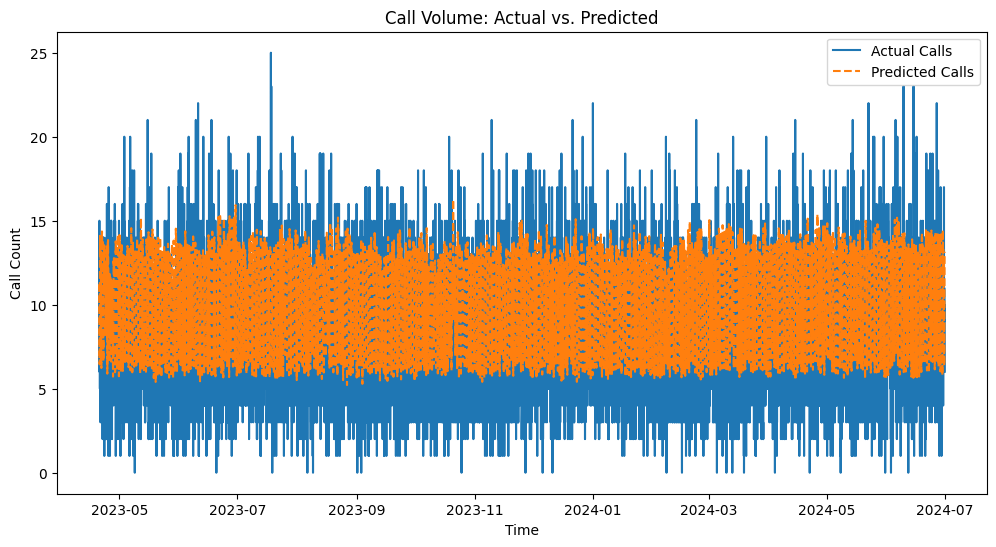

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Predict on the test set
test_predictions = model.predict(testing_generator)

# Rescale predictions back to original range because MinMaxScaler was used earlier
# Makes sure that number of predictions is the same as the number of actual values used
# The first values of length "length" are not used because they are used to predict the next value
num_predictions = len(testing_data.index[length:])
test_predictions_rescaled = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
test_predictions_rescaled = test_predictions_rescaled[:num_predictions] 


# Plot actual test data with vs predicted calls
plt.figure(figsize=(12, 6))
plt.plot(testing_data.index[length:], testing_data["call_count"].values[length:], label="Actual Calls")
plt.plot(testing_data.index[length:], test_predictions_rescaled, label="Predicted Calls", linestyle="dashed")
plt.legend()
plt.title("Call Volume: Actual vs. Predicted")
plt.xlabel("Time")
plt.ylabel("Call Count")
plt.show()


<h2>Calculate Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)</h2>


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Get actual values (scaled back)
actual_values = testing_data["call_count"].values[length:]

# Compute MAE & RMSE
mae = mean_absolute_error(actual_values, test_predictions_rescaled)
rmse = np.sqrt(mean_squared_error(actual_values, test_predictions_rescaled))

print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")


MAE (Mean Absolute Error): 4.65
RMSE (Root Mean Squared Error): 5.64
